<a href="https://colab.research.google.com/github/NateshReddy/Denoising-Algorithm-Implementation-/blob/master/cifar10_win.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide Inference Network for Image Denoising on Cifar10 dataset

In [1]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import layers
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 10
epochs = 30
saveDir = "/content/drive/My Drive/denoising task/model3_win"

In [3]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

## Adding noise

In [5]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

## Displaying noisy images

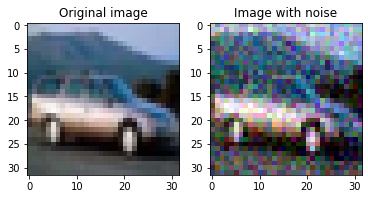

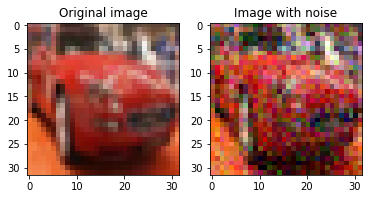

In [6]:
idx = 4
for i in range(2):
  plt.subplot(1,2,1)
  plt.imshow(train_data_clean[idx])
  plt.title('Original image')
  plt.subplot(1,2,2)
  plt.imshow(train_data_noisy[idx])
  plt.title('Image with noise')
  plt.show()
  idx = idx + 1

## Wide Inference Network

In [ ]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (7, 7), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
    
for i in range(3):
    x = Conv2D(64, (7, 7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
x = Conv2D(3, (7, 7), padding='same')(x)
x = BatchNormalization()(x)
output_img = layers.add([x, input_img])

In [ ]:
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_win5rb_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# Training


In [ ]:
history = model.fit(train_data_noisy, train_data_clean,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_data_noisy, test_data_clean),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 129s 3ms/step - loss: 0.2013 - val_loss: 0.0047

Epoch 00001: val_loss improved from inf to 0.00474, saving model to /content/drive/My Drive/denoising task/model3_winAutoEncoder_Cifar10_win5rb_weights.01-0.20-0.00.hdf5
Epoch 2/30
50000/50000 [==============================] - 121s 2ms/step - loss: 0.0018 - val_loss: 0.0016

Epoch 00002: val_loss improved from 0.00474 to 0.00156, saving model to /content/drive/My Drive/denoising task/model3_winAutoEncoder_Cifar10_win5rb_weights.02-0.00-0.00.hdf5
Epoch 3/30
50000/50000 [==============================] - 121s 2ms/step - loss: 0.0015 - val_loss: 0.0015

Epoch 00003: val_loss improved from 0.00156 to 0.00155, saving model to /content/drive/My Drive/denoising task/model3_winAutoEncoder_Cifar10_win5rb_weights.03-0.00-0.00.hdf5
Epoch 4/30
50000/50000 [==============================] - 121s 2ms/step - loss: 0.0014 - val_loss: 0.0015

Epoc

In [7]:
dae = load_model('/content/drive/My Drive/denoising task/model3_win/model3_winAutoEncoder_Cifar10_win5rb_weights.07-0.00-0.00.hdf5')

In [8]:
test_data_denoised = dae.predict(test_data_noisy)

## Visualize original image, noisy image and denoised image

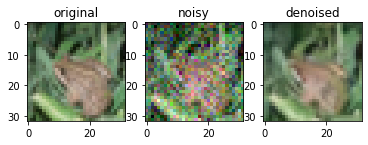

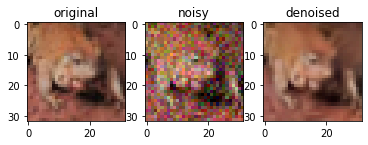

In [9]:
idx = 4
for i in range(2):
  plt.subplot(1,3,1)
  plt.imshow(test_data_clean[idx])
  plt.title('original')
  plt.subplot(1,3,2)
  plt.imshow(test_data_noisy[idx])
  plt.title('noisy')
  plt.subplot(1,3,3)
  plt.imshow(test_data_denoised[idx])
  plt.title('denoised')
  plt.show()
  idx = idx + 1

## Evaluation with the test dataset

We have calculated the PSNR and SSIM of the whole CIFAR10 test set. 

In [10]:
from skimage import metrics
psnr = metrics.peak_signal_noise_ratio(test_data_clean,test_data_denoised)
ssim = metrics.structural_similarity(test_data_clean,test_data_denoised,multichannel=True)
print("PSNR:",psnr,"\nSSIM:",ssim)

PSNR: 28.44936921013204 
SSIM: 0.9848844798406939
